In [1]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import glob
import numpy as np
import pandas as pd
import cv2

C:\Users\woodw\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\woodw\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, Softmax, LeakyReLU, Flatten, MaxPool2D, MaxPool3D, Embedding, GRU
from keras.layers.convolutional import Convolution2D, UpSampling2D, SeparableConv2D, UpSampling3D
from keras.layers import PReLU, LeakyReLU
from keras.models import Model
from keras.models import load_model
import keras.backend as K
from keras import layers
from keras import activations
from keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import sent_tokenize, word_tokenize 
import tensorflow as tf

Using TensorFlow backend.


In [3]:
img_paths = glob.glob('cleaned-data\*.jpg')

In [4]:
captions = pd.read_csv('./coco-captions-2017-clean.csv')

In [5]:
len(captions)

118287

In [47]:
annot_list = captions.values[:1600]
data = [] 
corpus_dict = {}
# iterate through each caption 
max_sequence_length = float("-inf")
for row in annot_list: 
    temp = [] 
      
    #tokenize the captions into words 
    for j in word_tokenize(row[2]): 
        temp.append(j.lower()) 
        corpus_dict[j.lower()] = 0
    if len(temp) > max_sequence_length:
        max_sequence_length = len(temp)
    data.append(temp) 

for index, word in enumerate(corpus_dict.keys()):
    corpus_dict[word] = index + 1
    
corpus_size = len(corpus_dict.keys())

In [48]:
max_sequence_length

27

In [49]:
w2v_model = Word2Vec.load('./text_encoding.bin')

In [50]:
len(w2v_model.wv.vocab)

13896

In [51]:
captions_X = []
caption_strings = []

for row in annot_list:
    caption_conv = []
    for word in word_tokenize(row[2].lower()):
        caption_conv.append(w2v_model[word])
    captions_X.append(np.array(caption_conv))
    caption_strings.append(row[2].lower())
    
    
    

C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [52]:
len(w2v_model.wv.vocab)

13896

In [53]:
# Pad with 0-vectors
for i in range(len(captions_X)):
    captions_X[i].resize((27, 100))


In [54]:
captions_X = np.array(captions_X)

In [15]:
len(captions_X)

1600

In [12]:
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [55]:
imgs_all = data_loader('./cleaned-data/')
imgs_y = imgs_all[:1600]

In [14]:
# autoencoder = load_model('./autoencoder-v2-models/autoencoder-v2-9k-epochs.h5')
import keras.metrics
def image_closeness(y_pred, y_true):
    return K.mean(1 - K.abs(y_pred - y_true), axis=-1)
keras.metrics.image_closeness = image_closeness

# autoencoder = load_model('./autoencoder-v3-models/autoencoder-v3-2k-epochs.h5')
autoencoder = load_model('./autoencoder-v2-models/autoencoder-v2-9k-epochs.h5') # transpose conv

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [15]:
decoder = autoencoder.layers[2]

In [16]:
for layer in decoder.layers:
    layer.trainable = False
decoder.trainable = False

In [245]:
def build_intermediate_model(input_shape, name='textencoder', encode_channels=[4, 8, 16, 32, 32]):
    embedding_size = 64
    gru_size = 1024
    input_length = 27
    input_layer = Input(shape=input_shape)
#     encoder_block = Embedding(434, 64, input_length=27)(input_layer)
    
    
    embedded_seq, state_i = GRU(gru_size, return_state=True)(input_layer)
    state_i = Dense(1024)(state_i)
    state_i = LeakyReLU()(state_i)

    
        
 
    encoder_block = Reshape((32, 32, 1))(state_i)
    
    for index, channel in enumerate(encode_channels):
        
        shortcut = Conv2D(channel, 3, padding='same', trainable=False)(encoder_block)
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)    
        
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        
        
        encoder_block = Add()([encoder_block, shortcut])
        
        #encoder_block = MaxPool2D()(encoder_block) # losses information density
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)

    output_layer = encoder_block
    return Model(input_layer, output_layer, name=name)

In [246]:
model_intermediate = build_intermediate_model((27, 100))

In [247]:
model_intermediate.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_179 (InputLayer)          (None, 27, 100)      0                                            
__________________________________________________________________________________________________
gru_19 (GRU)                    [(None, 1024), (None 3456000     input_179[0][0]                  
__________________________________________________________________________________________________
dense_109 (Dense)               (None, 1024)         1049600     gru_19[0][1]                     
__________________________________________________________________________________________________
leaky_re_lu_644 (LeakyReLU)     (None, 1024)         0           dense_109[0][0]                  
__________________________________________________________________________________________________
reshape_17

In [86]:
len(model_intermediate.layers)

55

In [239]:
def build_combined_model():
    input_caption = Input(shape=(27, 100))
    latent_representation = model_intermediate(input_caption)
    decoded_img = decoder(latent_representation)
    autoencoder = Model(input_caption, decoded_img, name="text2img")
    return autoencoder

In [240]:
model_text2img = build_combined_model()

In [21]:
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 27, 100)           0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        4580092   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 4,631,855
Trainable params: 4,564,394
Non-trainable params: 67,461
_________________________________________________________________


In [22]:
def image_closeness(y_true, y_pred):
#     return K.mean(K.equal(y_true, y_pred), axis=-1)
    return K.mean(1 - K.abs(y_true - y_pred), axis=-1)
import keras
keras.metrics.image_closeness = image_closeness

In [26]:
model_text2img.compile(optimizer='adam', loss='mse', metrics=[image_closeness, 'accuracy'])

In [ ]:
history = model_text2img.fit(captions_X, imgs_y, epochs=100, batch_size=32, shuffle=True)
plot_history(history)

Epoch 1/1000
1600/1600 [==============================] - 10s 6ms/step - loss: 0.0923 - image_closeness: 0.7502 - acc: 0.3778
Epoch 2/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0795 - image_closeness: 0.7628 - acc: 0.4049
Epoch 3/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0790 - image_closeness: 0.7630 - acc: 0.4182
Epoch 4/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0771 - image_closeness: 0.7652 - acc: 0.4298
Epoch 5/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0772 - image_closeness: 0.7651 - acc: 0.4300
Epoch 6/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0768 - image_closeness: 0.7654 - acc: 0.4288
Epoch 7/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0761 - image_closeness: 0.7665 - acc: 0.4387
Epoch 8/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0759 - image_closeness: 0.7667 - acc: 0.4383

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0180 - image_closeness: 0.9044 - acc: 0.6520
Epoch 121/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0183 - image_closeness: 0.9034 - acc: 0.6507A: 0s - loss: 0.0185 - image_closeness: 0.9028 - ac
Epoch 122/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0181 - image_closeness: 0.9040 - acc: 0.6491A: 3s - loss: 0.0179
Epoch 123/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0181 - image_closeness: 0.9042 - acc: 0.6530
Epoch 124/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0180 - image_closeness: 0.9043 - acc: 0.6505
Epoch 125/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0180 - image_closeness: 0.9045 - acc: 0.6553
Epoch 126/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0178 - image_closeness: 0.9055 - acc: 0.6573
Epoch 127/1000
1600/1600 [=============================

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0147 - image_closeness: 0.9152 - acc: 0.6887
Epoch 238/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0150 - image_closeness: 0.9140 - acc: 0.6853A: 3s - loss: 0.0147 
Epoch 239/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0149 - image_closeness: 0.9144 - acc: 0.6897
Epoch 240/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0148 - image_closeness: 0.9151 - acc: 0.6874A: 3s - loss: 0.0150 - ima
Epoch 241/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0147 - image_closeness: 0.9153 - acc: 0.6934
Epoch 242/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0149 - image_closeness: 0.9146 - acc: 0.6893
Epoch 243/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0145 - image_closeness: 0.9161 - acc: 0.6935
Epoch 244/1000
1600/1600 [==============================] - 5s 3ms/step - loss:

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0133 - image_closeness: 0.9202 - acc: 0.7038
Epoch 357/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0134 - image_closeness: 0.9198 - acc: 0.7053
Epoch 358/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0133 - image_closeness: 0.9203 - acc: 0.7071
Epoch 359/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0131 - image_closeness: 0.9213 - acc: 0.7049
Epoch 360/1000
1600/1600 [==============================] - ETA: 0s - loss: 0.0131 - image_closeness: 0.9209 - acc: 0.706 - 5s 3ms/step - loss: 0.0131 - image_closeness: 0.9209 - acc: 0.7063
Epoch 361/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0133 - image_closeness: 0.9203 - acc: 0.7043
Epoch 362/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0132 - image_closeness: 0.9206 - acc: 0.7056A: 2s - loss: 0.0133 - image_closeness: 0.9201  - ETA: 1s - los

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0130 - image_closeness: 0.9208 - acc: 0.7068
Epoch 476/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0128 - image_closeness: 0.9217 - acc: 0.7051
Epoch 477/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0128 - image_closeness: 0.9218 - acc: 0.7083
Epoch 478/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0127 - image_closeness: 0.9222 - acc: 0.7104
Epoch 479/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0126 - image_closeness: 0.9227 - acc: 0.7064
Epoch 480/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0126 - image_closeness: 0.9227 - acc: 0.7130
Epoch 481/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0125 - image_closeness: 0.9231 - acc: 0.7114
Epoch 482/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0125 - image_closeness: 0.9229 - acc: 0.7117

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0122 - image_closeness: 0.9238 - acc: 0.7122
Epoch 595/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0122 - image_closeness: 0.9239 - acc: 0.7111
Epoch 596/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0123 - image_closeness: 0.9235 - acc: 0.7127
Epoch 597/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0121 - image_closeness: 0.9248 - acc: 0.7169
Epoch 598/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0120 - image_closeness: 0.9250 - acc: 0.7142
Epoch 599/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0121 - image_closeness: 0.9246 - acc: 0.7092
Epoch 600/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0121 - image_closeness: 0.9246 - acc: 0.7140
Epoch 601/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0121 - image_closeness: 0.9244 - acc: 0.7162

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0117 - image_closeness: 0.9259 - acc: 0.7119
Epoch 711/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0118 - image_closeness: 0.9253 - acc: 0.7141
Epoch 712/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0118 - image_closeness: 0.9255 - acc: 0.7179
Epoch 713/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0117 - image_closeness: 0.9260 - acc: 0.7195A: 1s - loss: 0.0116 - image_closeness: 0
Epoch 714/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0116 - image_closeness: 0.9263 - acc: 0.7197
Epoch 715/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0116 - image_closeness: 0.9263 - acc: 0.7129
Epoch 716/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0117 - image_closeness: 0.9261 - acc: 0.7192A: 0s - loss: 0.0117 - image_closeness: 0.9259 - acc: 0.72
Epoch 717/1000
1600/1600 [=

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0114 - image_closeness: 0.9270 - acc: 0.7236
Epoch 830/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0113 - image_closeness: 0.9273 - acc: 0.7210A: 2s - loss: 0.0114 - image_clos
Epoch 831/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0113 - image_closeness: 0.9274 - acc: 0.7202A: 4s - loss: 0
Epoch 832/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0115 - image_closeness: 0.9267 - acc: 0.7160
Epoch 833/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0115 - image_closeness: 0.9267 - acc: 0.7184
Epoch 834/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0115 - image_closeness: 0.9268 - acc: 0.7194
Epoch 835/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0115 - image_closeness: 0.9267 - acc: 0.7194
Epoch 836/1000
1600/1600 [==============================] - 5s 3ms/step - loss

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0107 - image_closeness: 0.9297 - acc: 0.7225
Epoch 944/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0107 - image_closeness: 0.9300 - acc: 0.7225
Epoch 945/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9293 - acc: 0.7263
Epoch 946/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9292 - acc: 0.7251A: 3s - loss: 0.0111 
Epoch 947/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0107 - image_closeness: 0.9296 - acc: 0.7233A: 2s - loss: 0.0106 - image_closeness: 0. - ETA: 1s - loss: 0.0106 - image_closeness: 0.9302
Epoch 948/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9301 - acc: 0.7277A: 0s - loss: 0.0106 - image_closeness: 0.9301 - acc
Epoch 949/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0107 

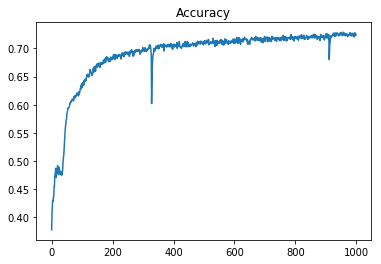

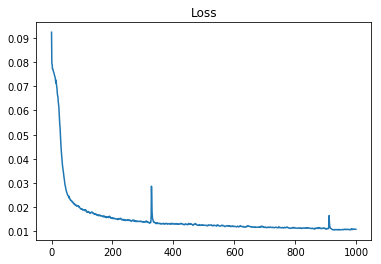

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9290 - acc: 0.7243
Epoch 2/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9288 - acc: 0.7264
Epoch 3/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9291 - acc: 0.7227
Epoch 4/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9291 - acc: 0.7224
Epoch 5/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9292 - acc: 0.7249
Epoch 6/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9294 - acc: 0.7259
Epoch 7/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9292 - acc: 0.7224
Epoch 8/1000
1600/1600 [=============================

Epoch 61/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0110 - image_closeness: 0.9287 - acc: 0.7254
Epoch 62/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9288 - acc: 0.7251
Epoch 63/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9287 - acc: 0.7251
Epoch 64/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0110 - image_closeness: 0.9286 - acc: 0.7229
Epoch 65/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0109 - image_closeness: 0.9289 - acc: 0.7217
Epoch 66/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0109 - image_closeness: 0.9291 - acc: 0.7281
Epoch 67/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0109 - image_closeness: 0.9289 - acc: 0.7238A: 1s - loss: 0.0109 - image_closeness: 0.9288 
Epoch 68/1000
1600/1600 [==============================] - 4s 3ms/step 

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9291 - acc: 0.7219A: 0s - loss: 0.0109 - image_closeness: 0.9289 - acc: 0.
Epoch 179/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9282 - acc: 0.7223A: 3s - loss: 0.
Epoch 180/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9280 - acc: 0.7241
Epoch 181/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9279 - acc: 0.7246
Epoch 182/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0112 - image_closeness: 0.9277 - acc: 0.7166A: 0s - loss: 0.0112 - image_closeness: 0.9274 - acc:
Epoch 183/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0112 - image_closeness: 0.9276 - acc: 0.7194
Epoch 184/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9280 - acc: 0.7209
E

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0111 - image_closeness: 0.9282 - acc: 0.7224A: 4s - loss: 0.
Epoch 299/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9281 - acc: 0.7215
Epoch 300/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9282 - acc: 0.7223
Epoch 301/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0110 - image_closeness: 0.9286 - acc: 0.7260
Epoch 302/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9291 - acc: 0.7259
Epoch 303/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9294 - acc: 0.7274
Epoch 304/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0107 - image_closeness: 0.9295 - acc: 0.7221
Epoch 305/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.93

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9300 - acc: 0.7222
Epoch 416/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0105 - image_closeness: 0.9304 - acc: 0.7297
Epoch 417/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9300 - acc: 0.7262
Epoch 418/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9300 - acc: 0.7310
Epoch 419/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9303 - acc: 0.7291A: 1s - loss: 0.0104 - image_closeness
Epoch 420/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0107 - image_closeness: 0.9295 - acc: 0.7218
Epoch 421/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9289 - acc: 0.7232
Epoch 422/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 -

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0104 - image_closeness: 0.9310 - acc: 0.7318A: 0s - loss: 0.0104 - image_closeness: 0.9308 - acc: 0.72 - ETA: 0s - loss: 0.0104 - image_closeness: 0.9309 - acc: 0.7
Epoch 528/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9314 - acc: 0.7305
Epoch 529/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9314 - acc: 0.7312
Epoch 530/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9298 - acc: 0.7209
Epoch 531/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9288 - acc: 0.7201
Epoch 532/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9290 - acc: 0.7246A: 2s - loss: 0.0108 - image_c
Epoch 533/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closenes

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0102 - image_closeness: 0.9316 - acc: 0.7306
Epoch 646/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9316 - acc: 0.7303
Epoch 647/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9314 - acc: 0.7293
Epoch 648/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0103 - image_closeness: 0.9312 - acc: 0.7293
Epoch 649/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0106 - image_closeness: 0.9300 - acc: 0.7272
Epoch 650/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9291 - acc: 0.7252
Epoch 651/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0107 - image_closeness: 0.9297 - acc: 0.7277
Epoch 652/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9292 - acc: 0.7257

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0102 - image_closeness: 0.9317 - acc: 0.7289
Epoch 766/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0102 - image_closeness: 0.9314 - acc: 0.7256
Epoch 767/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9314 - acc: 0.7303A: 0s - loss: 0.0102 - image_closeness: 0.9314 - acc:
Epoch 768/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9313 - acc: 0.7280
Epoch 769/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9313 - acc: 0.7321
Epoch 770/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9318 - acc: 0.7317
Epoch 771/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0101 - image_closeness: 0.9322 - acc: 0.7340
Epoch 772/1000
1600/1600 [==============================] - 4s 3ms/step -

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0101 - image_closeness: 0.9321 - acc: 0.7328
Epoch 879/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0101 - image_closeness: 0.9319 - acc: 0.7258
Epoch 880/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0101 - image_closeness: 0.9322 - acc: 0.7317
Epoch 881/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9324 - acc: 0.7322
Epoch 882/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9322 - acc: 0.7343A: 3s - loss: 0.0101
Epoch 883/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9316 - acc: 0.7285
Epoch 884/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9315 - acc: 0.7341
Epoch 885/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9322 - acc: 0.7295A: 1s - loss: 0.0099 - image_closeness: 0.9326 - 
Epoch 992/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9324 - acc: 0.7313A: 4s - loss
Epoch 993/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9324 - acc: 0.7304
Epoch 994/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9324 - acc: 0.7325
Epoch 995/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9325 - acc: 0.7323
Epoch 996/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9323 - acc: 0.7311
Epoch 997/1000
1600/1600 [==============================] - ETA: 0s - loss: 0.0100 - image_closeness: 0.9321 - acc: 0.7283- ETA: 4s - loss: 0. - 5s 3ms/step - loss: 0.0101 - image_closeness: 0

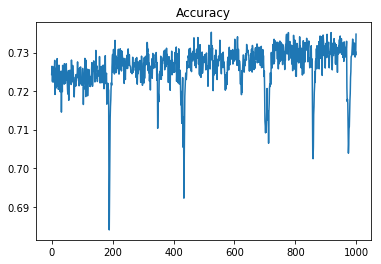

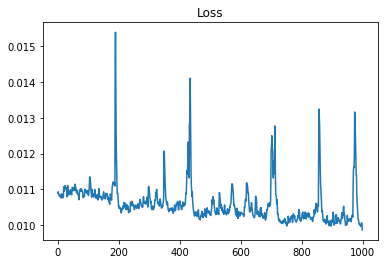

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [91]:
for i in range (1, 3):
    history = model_text2img.fit(captions_X, imgs_y, epochs=1000, batch_size=32, shuffle=True)
    print(str(i) + 'k epochs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    model_text2img.save('.\\text2img-models-v4\\text2img-' + str(i) + 'k-epochs.h5')
    plot_history(history)
#     show_converted(4)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [80]:
# model_text2img = load_model('./text2img-models-v2/text2img-1k-epochs.h5')
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 27, 100)           0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        4542844   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 4,594,607
Trainable params: 4,536,522
Non-trainable params: 58,085
_________________________________________________________________


In [50]:
model_text2img_t = load_model('./text2img-models-v4/text2img-2k-epochs.h5')
# model_text2img_u = load_model('./text2img-models-v3/text2img-3k-epochs.h5')

In [23]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
def rgb_imshow(img):
    figure(num=None, figsize=(10, 10), dpi=30, facecolor='w', edgecolor='k')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor((img).astype(np.float32), cv2.COLOR_BGR2RGB))
#     plt.show()
def show_converted(img_index, model_text2img, caption=None):
    # print(caption_strings[img_index])
    figure()
    if caption is None:
        img_input = imgs_y[img_index] #subset_X[img_index]
        plt.subplot(1,2,2)
        plt.title("Target image")
        rgb_imshow(img_input)
    
#     plt.subplot(1,2,1)
    
    if caption is None:
        plt.title("Image generated from:\n\"" + caption_strings[img_index] +"\"")
        decoded_img = model_text2img.predict(np.array([captions_X[img_index]]))[0]
    else:
        decoded_img = model_text2img.predict(np.array([caption]))[0]
    
#     figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')
    rgb_imshow(decoded_img)
#     plt.savefig('./gru-testing/gru-1024-dense-1024-residual/img-' + str(img_index),bbox_inches='tight')


# show_converted(2)
# show_converted(4)
# show_converted(18)
# show_converted(65)
# for i in range(65, 70):


img_num = 69
print(caption_strings[img_num])
rgb_imshow(imgs_all[img_num])
show_converted(3, model_text2img_t, caption=caption_encoding(caption_strings[img_num]))
show_converted(3, model_text2img_u, caption=caption_encoding(caption_strings[img_num]))




# decoded_img1 = model_text2img.predict(np.array([captions_X[4]]))[0]
# decoded_img2 = model_text2img.predict(np.array([captions_X[5]]))[0]

# flat_img = np.array(decoded_img2 - decoded_img1)
# flat_img = flat_img.flatten()
# nonzero_elems = [x for x in flat_img if x != 0]
# print (len(decoded_img1.flatten()))
# print (len(nonzero_elems))
# print (np.max(flat_img))


a white dog holding a purple frisbee in it's mouth.


NameError: name 'model_text2img_t' is not defined

In [24]:
def caption_encoding(string):
    caption_conv = []
    for word in word_tokenize(string.lower()):
        caption_conv.append(w2v_model[word])
    caption_conv = np.array(caption_conv)
    caption_conv.resize((27, 100))
    return caption_conv

In [25]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.title("Accuracy")
    plt.show()
    plt.plot(history.history['loss'])
    plt.title("Loss")
    plt.show()

In [ ]:
np.shape(model_text2img.predict(np.array([captions_X[0]]))[0])

In [210]:
def pad_text(text):
    paddings = tf.constant([[0, 0], [0, 52]])
    text = tf.pad(text, paddings, 'CONSTANT')
    return text

def build_discriminator(encode_channels=[8, 16, 32]):
    #text_input = Input(shape=(27, 100))
    image_input = Input(shape=(128, 128, 3))
    
    #text_attn = Flatten()(text_input)
    #resized_text = Lambda(pad_text)(resized_text)
    
    #concatentated_values = Concatenate(axis=3)([resized_text, image_input])
    
    for index, channel in enumerate(encode_channels):
        
#         shortcut = Conv2D(channel, 3, padding='same', trainable=False)(image_input if index == 0 else encoder_block)
        encoder_block = BatchNormalization()(image_input if index == 0 else encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        #encoder_block = Dropout(0.2)(encoder_block)
        
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        #encoder_block = Dropout(0.2)(encoder_block)
        
#         encoder_block = Add()([encoder_block, shortcut])
        
        encoder_block = Conv2D(channel, 3, padding='same', strides=2)(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        #encoder_block = Dropout(0.2)(encoder_block)
        
    
    encoder_block = Flatten()(encoder_block)
    #concatted = Concatenate()([encoder_block, text_attn])
    
    dense = Dense(1, activation='sigmoid')(encoder_block) #change to concatted if add text back
    
    return Model(image_input, dense, name='Discriminator') #Model([text_input, image_input], dense, name='Discriminator')
discriminator = build_discriminator()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_160 (InputLayer)       (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_349 (Bat (None, 128, 128, 3)       12        
_________________________________________________________________
leaky_re_lu_567 (LeakyReLU)  (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_679 (Conv2D)          (None, 128, 128, 8)       224       
_________________________________________________________________
batch_normalization_350 (Bat (None, 128, 128, 8)       32        
_________________________________________________________________
leaky_re_lu_568 (LeakyReLU)  (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_680 (Conv2D)          (None, 128, 128, 8)       584       
__________

In [211]:
def build_gan():
    input_caption = Input(shape=(27, 100))
    input_image = Input(shape=(128, 128, 3))
    generated_image = model_text2img(input_caption)
    discriminator_output = discriminator(generated_image) #discriminator([input_caption, generated_image])
    

    gan = Model(input_caption, [discriminator_output, generated_image])
    return gan

discriminator.trainable = False
g_adam = keras.optimizers.adam(lr=0.00005, beta_1=0.0, beta_2=0.999)
adversarial_net = build_gan()
adversarial_net.compile(optimizer=g_adam, loss=['binary_crossentropy', 'mse'], loss_weights=[1, 100], metrics=['binary_accuracy'])
adversarial_net.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_161 (InputLayer)       (None, 27, 100)           0         
_________________________________________________________________
text2img (Model)             (None, 128, 128, 3)       4631855   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 38861     
Total params: 4,670,716
Trainable params: 4,564,394
Non-trainable params: 106,322
_________________________________________________________________


In [248]:
model_intermediate = build_intermediate_model((27, 100))
model_text2img = build_combined_model()
discriminator = build_discriminator()
d_adam = keras.optimizers.adam(lr=0.00001, beta_1=0.0, beta_2=0.999)
discriminator.compile(optimizer=d_adam, loss='binary_crossentropy', metrics=['binary_accuracy'])
discriminator.trainable = False
adversarial_net = build_gan()
g_adam = keras.optimizers.adam(lr=0.0001, beta_1=0.0, beta_2=0.999)
adversarial_net.compile(optimizer=g_adam, loss=['binary_crossentropy', 'mse'], loss_weights=[1, 10], metrics=['binary_accuracy'])

In [242]:
captions_X = captions_X[:128]
imgs_y = imgs_y[:128]
caption_strings = caption_strings[:128]


epoch 1 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 2 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 3 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 4 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 5 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 6 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 7 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 8 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 9 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 10 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 11 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 12 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 13 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 14 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 15 of 1000
3/4 [=====================>........] - 

3/4 [=====================>........] - ETA: 0s1.0

epoch 122 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 123 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 124 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 125 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 126 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 127 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 128 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 129 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 130 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 131 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 132 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 133 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 134 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 135 of 1000
3/4 [=====================>.......

3/4 [=====================>........] - ETA: 0s1.0

epoch 240 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 241 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 242 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 243 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 244 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 245 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 246 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 247 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 248 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 249 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 250 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 251 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 252 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 253 of 1000
3/4 [=====================>.......

3/4 [=====================>........] - ETA: 0s1.0

epoch 359 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 360 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 361 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 362 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 363 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 364 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 365 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 366 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 367 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 368 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 369 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 370 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 371 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 372 of 1000
3/4 [=====================>.......

3/4 [=====================>........] - ETA: 0s1.0

epoch 477 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 478 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 479 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 480 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 481 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 482 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 483 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 484 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 485 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 486 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 487 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 488 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 489 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 490 of 1000
3/4 [=====================>.......

3/4 [=====================>........] - ETA: 0s1.0

epoch 596 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 597 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 598 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 599 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 600 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 601 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 602 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 603 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 604 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 605 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 606 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 607 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 608 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 609 of 1000
3/4 [=====================>.......

3/4 [=====================>........] - ETA: 0s1.0

epoch 715 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 716 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 717 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 718 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 719 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 720 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 721 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 722 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 723 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 724 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 725 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 726 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 727 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 728 of 1000
3/4 [=====================>.......

3/4 [=====================>........] - ETA: 0s1.0

epoch 833 of 1000
3/4 [=====================>........] - ETA: 0s0.984375

epoch 834 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 835 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 836 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 837 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 838 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 839 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 840 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 841 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 842 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 843 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 844 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 845 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 846 of 1000
3/4 [=====================>..

3/4 [=====================>........] - ETA: 0s1.0

epoch 951 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 952 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 953 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 954 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 955 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 956 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 957 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 958 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 959 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 960 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 961 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 962 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 963 of 1000
3/4 [=====================>........] - ETA: 0s1.0

epoch 964 of 1000
3/4 [=====================>.......

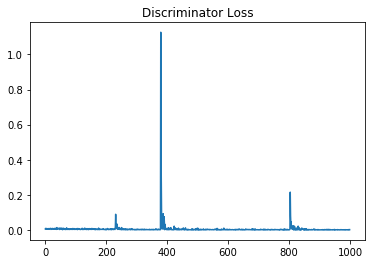

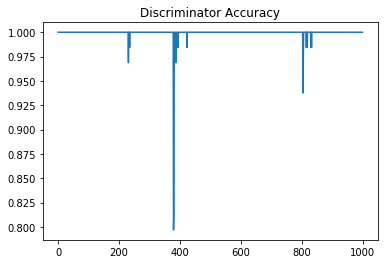

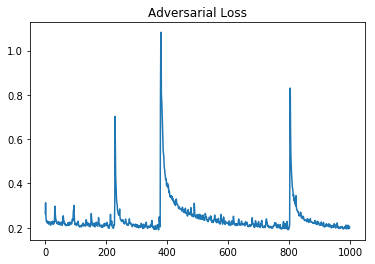

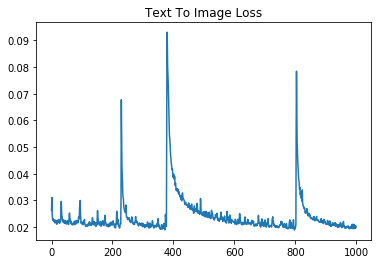

In [258]:
from keras.utils.generic_utils import Progbar
from time import time

d_loss_means = []
d_acc_means = []
a_loss_means = []
t_loss_means = []

BATCHSIZE = 32
EPOCHS = 1000
for epoch in range(EPOCHS):
    num_data_pts = len(captions_X)
    np.random.seed(epoch)
    np.random.shuffle(captions_X)
    np.random.seed(epoch)
    np.random.shuffle(imgs_y)
    np.random.seed(epoch)
    np.random.shuffle(caption_strings)

    d_hist_loss = []
    d_hist_acc = []
    a_hist_loss = []
    t_hist_loss = []
    print()
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(num_data_pts // BATCHSIZE)
    #print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    progress_bar = Progbar(target=int(num_data_pts // (BATCHSIZE)))
    minibatches_size = BATCHSIZE
    start_time = time()
    
    for index in range(int(num_data_pts // (BATCHSIZE))):
        progress_bar.update(index)
        
        #print(f'{BATCHSIZE*index}:{(BATCHSIZE*(index+1))}')
        images_real = imgs_y[BATCHSIZE*index:(BATCHSIZE*(index+1))]
        captions_batch = captions_X[BATCHSIZE*index:(BATCHSIZE*(index+1))]
        #print(edges_batch.shape)
        labels_fake = np.zeros([BATCHSIZE,1], dtype=np.float32)
        labels_real = np.ones([BATCHSIZE,1], dtype=np.float32)
        
        images_fake = model_text2img.predict(captions_batch)
        train_imgs = np.concatenate((images_real, images_fake))
        train_captions = np.concatenate((captions_batch, captions_batch))
        train_labels = np.concatenate((labels_real, labels_fake))
        
#         np.random.seed(index)
#         np.random.shuffle(train_imgs)
#         np.random.seed(index)
#         np.random.shuffle(train_captions)
#         np.random.seed(index)
#         np.random.shuffle(train_labels)
        
#         d_loss, d_acc = discriminator.train_on_batch([train_captions,train_imgs], train_labels)
 
        np.random.seed(index)
        np.random.shuffle(train_imgs)
        np.random.seed(index)
        np.random.shuffle(train_captions)
        np.random.seed(index)
        np.random.shuffle(train_labels)
        if index % 4 == 0:
            d_loss, d_acc = discriminator.train_on_batch(train_imgs, train_labels)
            d_hist_loss.append(d_loss)
            d_hist_acc.append(d_acc)
        #_loss = discriminator.train_on_batch([train_captions,train_imgs], train_labels)
        #d_loss_r = discriminator.train_on_batch([captions_batch,images_real], labels_real)
        
        
        a_loss_1, _, t_loss, _, _ = adversarial_net.train_on_batch(captions_batch, [labels_real, images_real])
        a_hist_loss.append(a_loss_1)
        t_hist_loss.append(t_loss)
        
        #discriminator.trainable = True
    
    t_loss_means.append(np.mean(t_hist_loss))
    d_loss_means.append(np.mean(d_hist_loss))
    a_loss_means.append(np.mean(a_hist_loss))
    d_acc_means.append(np.mean(d_hist_acc))
    print(np.mean(d_hist_acc))
    #gen_imgs = model_text2img_t.predict(captions_batch)

plt.title('Discriminator Loss')
plt.plot(d_loss_means)
plt.show()
plt.title('Discriminator Accuracy')
plt.plot(d_acc_means)
plt.show()
plt.title('Adversarial Loss')
plt.plot(a_loss_means)
plt.show()
plt.title('Text To Image Loss')
plt.plot(t_loss_means)
plt.show()
# adversarial_net.save_weights('.\\gan-v1\\gan-2k-epochs-weights.h5')
# model_text2img.save_weights('.\\gan-v1\\text2img-2k-epochs-weights.h5')

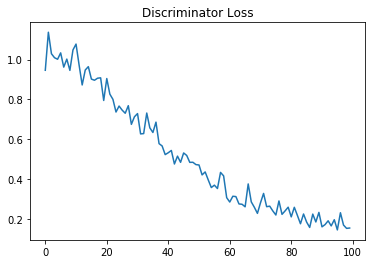

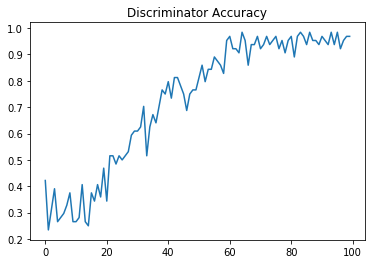

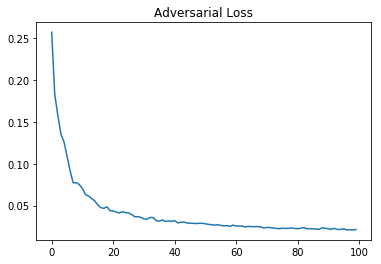

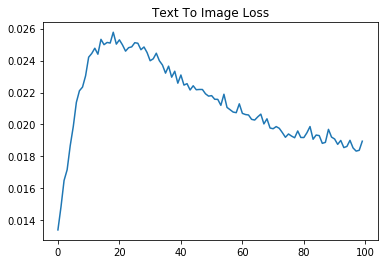

In [113]:
plt.title('Discriminator Loss')
plt.plot(d_loss_means)
# plt.savefig('./gan-v1/discriminator_loss-2k')
plt.show()
plt.title('Discriminator Accuracy')
plt.plot(d_acc_means)
# plt.savefig('./gan-v1/discriminator_acc-2k')
plt.show()
plt.title('Adversarial Loss')
plt.plot(a_loss_means)
# plt.savefig('./gan-v1/adversarial_loss-2k')
plt.show()
plt.title('Text To Image Loss')
plt.plot(t_loss_means)
# plt.savefig('./gan-v1/text2img_loss-2k')
plt.show()

a female in military uniform cutting a businessman's neck tie


C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


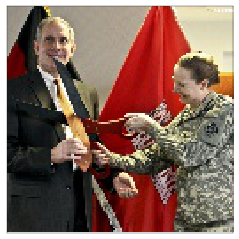

<Figure size 432x288 with 0 Axes>

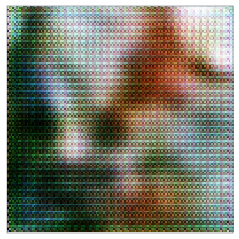

In [264]:
img_num = 98

print(caption_strings[img_num])

rgb_imshow(imgs_y[img_num]) 
show_converted(img_num, model_text2img, caption=caption_encoding(caption_strings[img_num]))


In [80]:

model_intermediate = build_intermediate_model((27, 100))
model_text2img = build_combined_model()
#model_text2img.compile(optimizer='adam', loss='mse', metrics=[image_closeness, 'accuracy'])
discriminator = build_discriminator()

discriminator.compile(optimizer=d_adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

discriminator.trainable = False
adversarial_net = build_gan()
adversarial_net.compile(optimizer=g_adam, loss=['binary_crossentropy', 'mse'], loss_weights=[1, 10], metrics=['binary_accuracy'])






In [142]:
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [117]:
for i in range(25):
    discriminator.trainable = False
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    discriminator.trainable = True
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
